In [ ]:
'''
## Overview
This notebook loads all the valid networks from 
15_4_2I1R_zebrafish_network_unequal_HD_3r.ipynb and use the trajectories of
all fish (excluding fish with too few rotations (<3 either side)) as inputs
to examine the performance of the networks in tracking the true head direction.


## Author
Siyuan Mei (mei@bio.lmu.de)


## Last update
2025-9-14
'''
%load_ext autoreload
%autoreload 2

import numpy as np
from matplotlib import pyplot as plt
from tqdm import tqdm
from sklearn.model_selection import ParameterGrid
from scipy.integrate import solve_ivp
from matplotlib import colors
from scipy.signal import find_peaks
from scipy.stats import pearsonr
import pandas as pd
from sklearn.metrics import mean_squared_error

import HD_utils.circular_stats as cstat
from HD_utils.network import *
from HD_utils.matrix import *
from HD_utils.adap_sim_move import *
from HD_utils.adap_sim_stable import *
from HD_utils.IO import *
from HD_utils.plot import *
from HD_utils.comput_property import *
from HD_utils.exam import *

# Load fish's trajectory

In [ ]:
from HD_utils.HD_functions import *
from lotr import LotrExperiment
from lotr.default_vals import TURN_BIAS
from lotr.behavior import get_bouts_props_array
from HD_utils.defaults import DATA_FOLDERS
fish_num = len(DATA_FOLDERS)

In [ ]:
traj_fish = []
for fish in tqdm(range(fish_num)):
    exp = LotrExperiment(DATA_FOLDERS[fish])
    fs = exp.fn
    cell_num = len(exp.hdn_indexes)
    theta_rotation = get_bouts_props_array(exp.n_pts, exp.bouts_df, min_bias=TURN_BIAS, selection="all", value="bias")
    theta_rotation = replace_consecutive_element(theta_rotation, 10, 0) # replace any consecutive 0s which repeated more than x times (x/5s) by 0s repeating x times
    angle = np.concatenate([[0], np.cumsum(theta_rotation)])
    angVel = np.concatenate([[0], theta_rotation]) * fs
    t = np.arange(0, len(angle) / fs, 1/fs)
    df_temp = pd.DataFrame({'t': t, 'angle_expand': angle, 'angVel': angVel})
    traj_fish.append(df_temp)

100%|██████████| 31/31 [00:19<00:00,  1.61it/s]


# Load Model

In [4]:
def asy_theta_range(theta_range_sym, shift):
    dtheta = ((np.cos(theta_range_sym + shift) + 1) * 0.05 + 0.1)
    dtheta = dtheta / np.sum(dtheta) * 2 * np.pi
    theta_range = np.cumsum(dtheta) - dtheta/2
    return dtheta, theta_range - np.pi

# Simulation theta precision
theta_num = 50

dtheta_sym = (2*np.pi)/theta_num
theta_range_sym = np.arange(-np.pi+dtheta_sym/2, np.pi, dtheta_sym)

dtheta = np.repeat(dtheta_sym, theta_num)
theta_range = [theta_range_sym]

for shift in [-np.pi/2, np.pi/2]:
    dthetai, theta_rangei = asy_theta_range(theta_range_sym, shift)
    dtheta = np.concatenate((dtheta, dthetai))
    theta_range.append(theta_rangei) # in the order: center, left, right

# Changeable parameters
ring_num = 3
actfun = max0x
weight_fun = vonmises_weight_2i1r_unequal_theta
search_pars = {'JI': np.linspace(-50,0,6), 'JE': np.linspace(0,50,6), 'K0': np.linspace(-50,0,6), 'kappa': np.logspace(-0.2,1,6)}
file_pre_name = 'new_15_1_copy'
# Default parameters
inputs = np.array([-1, -0.6, -0.3, -0.1, 0, 0.1, 0.3, 0.6, 1])
net_diff_equa = net_diff_equa_f_in
phi = -np.pi * 8/9
tau = 20 # ms
b0 = 1
bc = 1
# Generated parameters
par_num = len(search_pars)
search_num = len(ParameterGrid(search_pars))
zeroid = np.where(inputs == 0)[0][0]
par_names = list(search_pars.keys())
input_num = len(inputs)

In [5]:
network_evals, network_evaldes, network_acvs, network_pars, network_ts = load_pickle(
    ['evals', 'eval_des', 'acvs', 'pars', 'ts'], weight_fun, actfun, file_pre_name)
valid_index_s = np.where(network_evals == 'valid')[0]
valids_num = len(valid_index_s)

Vels, network_eval_moving, network_eval_moving_des, network_acvs_moving, network_ts_moving, network_eval_moving_sum = load_pickle(
    ['moving_slope', 'moving_eval', 'moving_eval_des', 'moving_acvs', 'moving_ts', 'moving_eval_sum'], weight_fun, actfun, file_pre_name)

stable_mov_range, stable_mov_range_id, linear_mov_range, linear_mov_range_id = \
    cal_linear_range(network_eval_moving, Vels, inputs, valid_index_s)
valid_index_linear_move = np.where(np.diff(linear_mov_range_id, axis=1) == 8)[0]

# Changing inputs

In [ ]:
sim_prefix = 'new_15_3'

net_id_list = []
traj_i_list = []
ratio_list = []
r_list = []
net_phase_list = []
phase_raw_list = []
mse_list = []

counter = 0

# for i_num, i in enumerate(([valid_index_linear_move[32]])):
for i_num, i in enumerate(tqdm(valid_index_linear_move)):
    weights = weight_fun(*network_pars[i], phi, theta_num, theta_range, dtheta)
    vel = Vels[i,:,0] # central ring's velocity
    s1 = np.concatenate( [network_acvs[i][0,:,-1], network_acvs[i][1,:,-1], network_acvs[i][2,:,-1]] )
    slope, _, _, _ = np.linalg.lstsq(inputs.reshape(-1,1), vel * np.pi * 2, rcond=None)
    slope = slope[0]
    
    ratio_list_temp = []
    for j in tqdm( np.arange(len(traj_fish))  ):
        traj_sample = traj_fish[j]
        t0 = traj_sample.t[0]
        t_spans, ratiovs, t_evals = cal_sim_t_angVel(traj_sample, 'fish', slope)
        
        for si in range(len(ratiovs)):
            t_span = t_spans[si]
            t_len = t_span[-1] - t_span[0]
            
            t_eval = t_evals[si]
            tgap = np.mean(np.diff(t_eval))
            ratiov = ratiovs[si]
            b_array = steady_inputb_2rr_b_increase(bc, b0, ratiov, theta_num)  # input
            ## Compute network dynamics 
            y0 = s1 if si == 0 else y[:,-1].copy()
            
            y_temp, _, _, _ = inte_check_move(net_diff_equa, y0, weights, tau, b_array, theta_num, actfun, 
                        t_max1=t_len, t_max2=t_len, rec_t_gap=tgap, exam_interval=t_len)
            
            if si == 0:
                y = y_temp
            else:
                # y = net_var_append(y, y_temp)
                y = np.concatenate([y, y_temp[:,1:]], axis=1)
        
        phase_raw = cal_peak_loc_auto(y, theta_range[0])
        net_phase = cstat.rerange_expand(phase_raw.mean(axis=0)) if ring_num == 2 else cstat.rerange_expand(phase_raw[0])
        # if 2 ring: average of the left and right; if 3 ring: select the central ring; if 1 ring: the only ring
        true_HD = (traj_sample.angle_expand.values)
        r = np.corrcoef(true_HD, net_phase)[0,1]
        # print(r)
        tp_ratio, _, _, _ = np.linalg.lstsq((net_phase-net_phase[0]).reshape(-1,1), true_HD, rcond=None) # zero intercept
        tp_ratio = tp_ratio[0]

        net_id_list.append(i)
        traj_i_list.append(j)
        r_list.append(r)
        ratio_list.append(tp_ratio)
        ratio_list_temp.append(tp_ratio)
        net_phase_list.append(net_phase)
        phase_raw_list.append(phase_raw)

    mean_ratio = np.mean(ratio_list_temp)
    for j_enu, j in enumerate(range(len(traj_fish))):
        traj_sample = traj_fish[j]
        true_HD = (traj_sample.angle_expand.values)
        net_phase = net_phase_list[j_enu + len(traj_fish) * i_num]
        mse = mean_squared_error(true_HD, (net_phase - net_phase[0]) * mean_ratio)
        mse_list.append(mse)

net_performance = pd.DataFrame({'net_id': net_id_list, 'traj_i': traj_i_list, 'r': r_list, 'ratio': ratio_list, 'mse': mse_list})
pd.to_pickle(net_performance, SIM_RESULT_PATH + sim_prefix + 'net_performance.pkl')

with open(SIM_RESULT_PATH + sim_prefix + 'net_phase_list.pkl', 'wb') as f:
    pickle.dump(net_phase_list, f)
with open(SIM_RESULT_PATH + sim_prefix + 'phase_raw_list.pkl', 'wb') as f:
    pickle.dump(phase_raw_list, f)

100%|██████████| 54/54 [2:39:28<00:00, 177.20s/it]


# Inspection

In [ ]:
net_performance = pd.read_pickle(SIM_RESULT_PATH / f"{sim_prefix}net_performance.pkl")

with open(SIM_RESULT_PATH / f"{sim_prefix}net_phase_list.pkl", 'rb') as f:
    net_phase_list = pickle.load(f)

with open(SIM_RESULT_PATH / f"{sim_prefix}phase_raw_list.pkl", 'rb') as f:
    phase_raw_list = pickle.load(f)

In [13]:
net_performance.mean()

r            0.980731
ratio        1.073416
mse          7.228355
traj_i      15.000000
net_id    1061.074074
dtype: float64

In [14]:
net_performance.std()

net_id    183.152122
traj_i      8.946945
r           0.112567
ratio       0.535292
mse        67.916078
dtype: float64

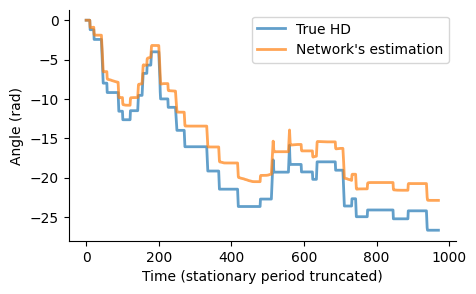

In [ ]:
fig, ax = plt.subplots(figsize=(5, 3))

fishi = 1
true_HD = traj_fish[fishi].angle_expand.values
net_phase = net_phase_list[fishi]

ax.plot(true_HD, label='True HD', lw=2, alpha=0.7)
ax.plot(net_phase-net_phase[0], label='Network\'s estimation', lw=2, alpha=0.7)
ax.set_xlabel('Time (stationary period truncated)')
# ax.set_xticks([])
ax.set_ylabel('Angle (rad)')
ax.legend()

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
# ax.set_xlim(0,60)
plt.show()

np.save(SIM_RESULT_PATH / f"{sim_prefix}a_net_phase.npy", net_phase)
np.save(SIM_RESULT_PATH / f"{sim_prefix}a_traj.npy", true_HD)